<a href="https://colab.research.google.com/github/CS20M038/CS6910-assignment_3/blob/main/Assignment3_version2_MultiLayerLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Import Libraries
from random import randint
from numpy import array
from numpy import argmax
import keras.backend as K
from tensorflow.keras import models
from numpy import array_equal
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Input
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K

from scipy.ndimage.interpolation import shift
import csv
import random

In [ ]:
#@title Check GPU
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
input_characters =[' ']
target_characters = [' ']

In [ ]:
input_dict=['-PAD-']
target_dict=['-PAD-']
eng_alphabets = 'abcdefghijklmnopqrstuvwxyz'
pad_char = '-PAD-'

eng_alpha2index = {pad_char: 0}
for index, alpha in enumerate(eng_alphabets):
    eng_alpha2index[alpha] = index+1
    input_dict.append(alpha)

print(eng_alpha2index)
print(input_dict)
# Hindi Unicode Hex Range is 2304:2432. Source: https://en.wikipedia.org/wiki/Devanagari_(Unicode_block)

hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_alpha2index = {pad_char: 0}
for index, alpha in enumerate(hindi_alphabets):
    hindi_alpha2index[alpha] = index+1
    target_dict.append(alpha)
    #print(alpha)

print(hindi_alpha2index)
print(target_dict)


# Hindi Unicode Hex Range is 2304:2432. Source: https://en.wikipedia.org/wiki/Devanagari_(Unicode_block)

hindi_alphabets = [chr(alpha) for alpha in range(2304, 2432)]
hindi_alphabet_size = len(hindi_alphabets)

hindi_index2alpha = {0: pad_char}
for index, alpha in enumerate(hindi_alphabets):
    hindi_index2alpha[index+1] = alpha
   # target_dict.append(alpha)
    #print(alpha)

print(hindi_index2alpha)

eng_alphabets = 'abcdefghijklmnopqrstuvwxyz'
eng_index2alpha = {0: pad_char}
for index, alpha in enumerate(eng_alphabets):
    eng_index2alpha[index+1] = alpha
   # target_dict.append(alpha)
    #print(alpha)

print(eng_index2alpha)

{'-PAD-': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
['-PAD-', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
{'-PAD-': 0, 'ऀ': 1, 'ँ': 2, 'ं': 3, 'ः': 4, 'ऄ': 5, 'अ': 6, 'आ': 7, 'इ': 8, 'ई': 9, 'उ': 10, 'ऊ': 11, 'ऋ': 12, 'ऌ': 13, 'ऍ': 14, 'ऎ': 15, 'ए': 16, 'ऐ': 17, 'ऑ': 18, 'ऒ': 19, 'ओ': 20, 'औ': 21, 'क': 22, 'ख': 23, 'ग': 24, 'घ': 25, 'ङ': 26, 'च': 27, 'छ': 28, 'ज': 29, 'झ': 30, 'ञ': 31, 'ट': 32, 'ठ': 33, 'ड': 34, 'ढ': 35, 'ण': 36, 'त': 37, 'थ': 38, 'द': 39, 'ध': 40, 'न': 41, 'ऩ': 42, 'प': 43, 'फ': 44, 'ब': 45, 'भ': 46, 'म': 47, 'य': 48, 'र': 49, 'ऱ': 50, 'ल': 51, 'ळ': 52, 'ऴ': 53, 'व': 54, 'श': 55, 'ष': 56, 'स': 57, 'ह': 58, 'ऺ': 59, 'ऻ': 60, '़': 61, 'ऽ': 62, 'ा': 63, 'ि': 64, 'ी': 65, 'ु': 66, 'ू': 67, 'ृ': 68, 'ॄ': 6

In [ ]:
def readXmlDataset(filename):
        tsv_file = open(filename)
        read_tsv = csv.reader(tsv_file, delimiter="\t")
        lang1_words = []
        lang2_words = []

        for row in read_tsv:
            lang2_words.append(row[0])
            lang1_words.append(row[1])
            #print(row[0])

        return lang1_words, lang2_words
train_input_texts, train_target_texts = readXmlDataset('hi.translit.sampled.train.tsv')
test_input_texts, test_target_texts = readXmlDataset('hi.translit.sampled.test.tsv')

In [ ]:
def word_rep(word, letter2index, device = 'cpu'):
    rep = np.zeros((len(word)+1,  129))
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        rep[letter_index][pos] = 1
    pad_pos = letter2index[pad_char]
    rep[letter_index+1][pad_pos] = 1
    return rep

def gt_rep(word, letter2index, device = 'cpu'):
    gt_rep = np.zeros([len(word)+1, 1], dtype=np.long)
    for letter_index, letter in enumerate(word):
        pos = letter2index[letter]
        gt_rep[letter_index][0] = pos
    gt_rep[letter_index+1][0] = letter2index[pad_char]
    return gt_rep
    word_rep('abc',eng_alpha2index).shape
    x=gt_rep('abc',eng_alpha2index)

In [ ]:
def createDataset(dataset,letter2index):
    X_train=[]
    for i,data in enumerate(dataset):
        #print(data)
        X_train.append(word_rep(data,letter2index))
    X_train = np.array(X_train)
    return X_train

In [ ]:
X_train = createDataset(train_input_texts,eng_alpha2index)
y_train = createDataset(train_target_texts,hindi_alpha2index)
X_test = createDataset(test_input_texts,eng_alpha2index)
y_test = createDataset(test_target_texts,hindi_alpha2index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [ ]:
print(len(eng_alpha2index))
#a=[0]*(len(eng_alpha2index)-1)
a=[0]*128
eng_pad=[1]
eng_pad=eng_pad+a
print(eng_pad)
print(len(hindi_alpha2index))
a=[0]*128
hindi_pad=[1]
hindi_pad=hindi_pad+a
print(hindi_pad)

27
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
129
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
def one_hot_encode(sequence, n_unique):
	encoding = list()
	for value in sequence:
		vector = [0 for _ in range(n_unique)]
		vector[value] = 1
		encoding.append(vector)
	return array(encoding)

In [ ]:
one_hot_encode([1,2,3],10)

array([[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [ ]:
def one_hot_decode(encoded_seq):
	return [argmax(vector) for vector in encoded_seq]
'''d=one_hot_decode(y_train_padded[5])
c=hindi_index2alpha[6]+hindi_index2alpha[3]+hindi_index2alpha[22]+hindi_index2alpha[66]+hindi_index2alpha[49]+hindi_index2alpha[64]+hindi_index2alpha[37]+hindi_index2alpha[0]
c'''

'd=one_hot_decode(y_train_padded[5])\nc=hindi_index2alpha[6]+hindi_index2alpha[3]+hindi_index2alpha[22]+hindi_index2alpha[66]+hindi_index2alpha[49]+hindi_index2alpha[64]+hindi_index2alpha[37]+hindi_index2alpha[0]\nc'

In [ ]:
max_input_sequence= max(len(seq) for seq in X_train)
max_output_sequence= max(len(seq) for seq in y_train)

print('max_input_sequence: ', max_input_sequence)
print('max_output_sequence: ', max_output_sequence)

max_input_sequence:  21
max_output_sequence:  20


In [ ]:
from keras.preprocessing.sequence import pad_sequences
X_train_padded = pad_sequences(X_train, maxlen= max_input_sequence, padding='post', value=eng_pad)
print("X_train shape: ",X_train.shape)
print("X_train_padded shape: ",X_train_padded.shape)

y_train_padded = pad_sequences(y_train, maxlen= max_output_sequence, padding='post', value=hindi_pad)
print("y_train shape: ",y_train.shape)
print("y_train_padded shape: ",y_train_padded.shape)

X_train shape:  (44204,)
X_train_padded shape:  (44204, 21, 129)
y_train shape:  (44204,)
y_train_padded shape:  (44204, 20, 129)


In [ ]:
i=0
print("____Sample Input (Raw Format)____")
print("Original:\n", one_hot_decode(X_train[i]))
print("Padded:\n",one_hot_decode(X_train_padded[i]))
print("____Corresponding Output (Raw Format)____")
print("Original:\n", one_hot_decode(y_train[i]))
print("Padded:\n",one_hot_decode(y_train_padded[i]))

____Sample Input (Raw Format)____
Original:
 [1, 14, 0]
Padded:
 [1, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
____Corresponding Output (Raw Format)____
Original:
 [6, 3, 0]
Padded:
 [6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [ ]:
X_test_padded = pad_sequences(X_test, maxlen= max_input_sequence, padding='post', 
                              value=eng_pad)
print("X_test shape: ",X_test.shape)
print("X_test_padded shape: ",X_test_padded.shape)

y_test_padded = pad_sequences(y_test, maxlen= max_output_sequence, padding='post', 
                              value=hindi_pad)
print("y_test shape: ",y_test.shape)
print("y_test_padded shape: ",y_test_padded.shape)

X_test shape:  (4502,)
X_test_padded shape:  (4502, 21, 129)
y_test shape:  (4502,)
y_test_padded shape:  (4502, 20, 129)


In [ ]:
#Prepare TRAIN data set
input_dimension = len(hindi_alpha2index)   #@param {type:"integer"}
encoder_input_data = X_train_padded.copy()
decoder_target_data = y_train_padded.copy()
decoder_input_data = decoder_target_data.copy()
for i, samples in enumerate(decoder_target_data):
  seq = one_hot_decode(samples)
  shifted= shift(seq, 1, cval=0)
  decoder_input_data[i]=one_hot_encode(shifted,input_dimension)
print("Data for Train")
print('encoder_input_data (X): ', one_hot_decode(encoder_input_data[1]))
print('decoder_input_data (teacher forcing): ',one_hot_decode(decoder_input_data[1]))
print('decoder_target_data (y):',one_hot_decode(decoder_target_data[1]))
print(encoder_input_data.shape)

#Prepare TEST data set
encoder_input_test = X_test_padded.copy()
decoder_target_test = y_test_padded.copy()
decoder_input_test= decoder_target_test.copy()
for i, samples in enumerate(decoder_target_test):
  seq = one_hot_decode(samples)
  shifted= shift(seq, 1, cval=0)
  decoder_input_test[i]=one_hot_encode(shifted,input_dimension)

Data for Train
encoder_input_data (X):  [1, 14, 11, 7, 1, 14, 9, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
decoder_input_data (teacher forcing):  [0, 6, 3, 22, 24, 36, 64, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
decoder_target_data (y): [6, 3, 22, 24, 36, 64, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
(44204, 21, 129)


In [ ]:
#@title LSTMoutputDimension
#LSTMoutputDimension = 256 #@param {type:"integer"}

In [ ]:
# Define an input sequence and process it.
latent_dims = [1024, 512,  256]
encoder_inputs= Input(shape=(max_input_sequence, input_dimension), name='encoder_inputs')

#masking = tf.keras.layers.Masking(mask_value= hindi_pad)
#encoder_inputs = masking(encoder_inputs)

outputs = encoder_inputs
encoder_states = []
for j in range(len(latent_dims))[::-1]:
    outputs, h, c = LSTM(latent_dims[j], return_state=True, return_sequences=bool(j))(outputs)
    encoder_states += [h, c]



decoder_inputs = Input(shape=(None, input_dimension), name='decoder_inputs')
outputs = decoder_inputs
output_layers = []
for j in range(len(latent_dims)):
    output_layers.append(
        LSTM(latent_dims[len(latent_dims) - j - 1], return_sequences=True, return_state=True)
    )
    outputs, dh, dc = output_layers[-1](outputs, initial_state=encoder_states[2*j:2*(j+1)])


decoder_dense = Dense(input_dimension, activation='softmax')
decoder_outputs = decoder_dense(outputs)



# put together
model_encoder_training = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='model_encoder_training')

Model: "model_encoder_training"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_inputs (InputLayer)     [(None, 21, 129)]    0                                            
__________________________________________________________________________________________________
decoder_inputs (InputLayer)     [(None, None, 129)]  0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 21, 256), (N 395264      encoder_inputs[0][0]             
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, None, 256),  395264      decoder_inputs[0][0]             
                                                                 lstm[0][1]  

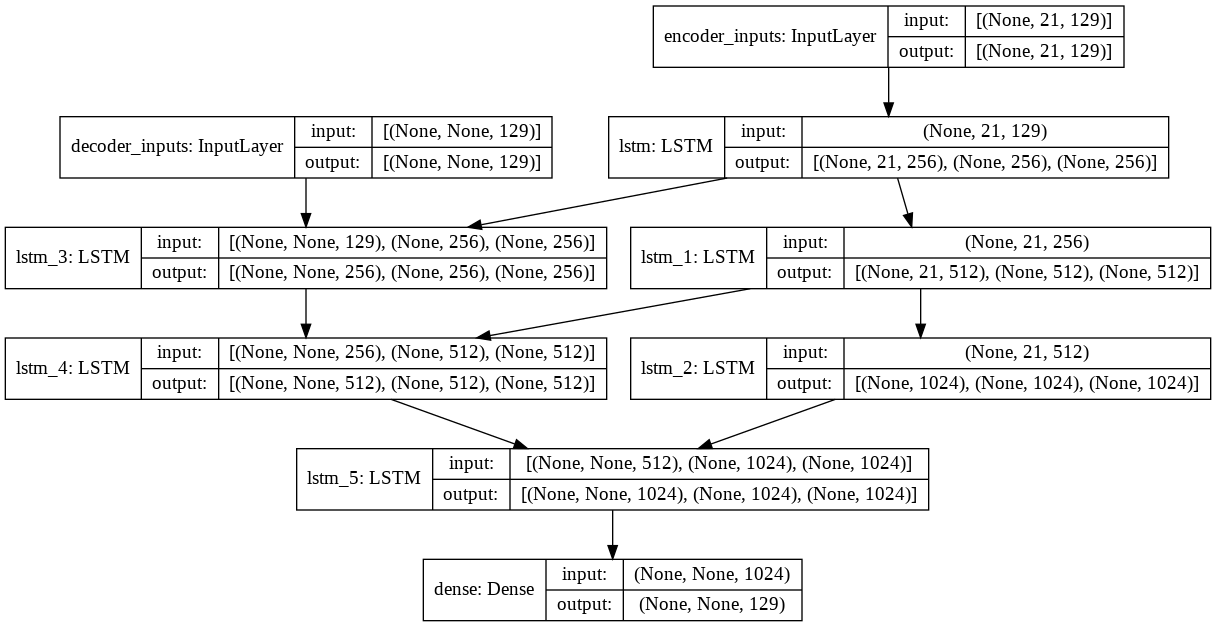

In [ ]:
model_encoder_training.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_encoder_training.summary()
plot_model(model_encoder_training, show_shapes=True)

In [ ]:
model_encoder_training.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=64,
          epochs=55,
          validation_split=0.2)

Epoch 1/55
553/553 [==============================] - 73s 65ms/step - loss: 1.2323 - accuracy: 0.7153 - val_loss: 1.2583 - val_accuracy: 0.7433
Epoch 2/55
553/553 [==============================] - 34s 62ms/step - loss: 0.6141 - accuracy: 0.8188 - val_loss: 0.9518 - val_accuracy: 0.7833
Epoch 3/55
553/553 [==============================] - 34s 61ms/step - loss: 0.3948 - accuracy: 0.8763 - val_loss: 0.7967 - val_accuracy: 0.8090
Epoch 4/55
553/553 [==============================] - 34s 61ms/step - loss: 0.2317 - accuracy: 0.9254 - val_loss: 0.7045 - val_accuracy: 0.8341
Epoch 5/55
553/553 [==============================] - 34s 61ms/step - loss: 0.1543 - accuracy: 0.9503 - val_loss: 0.7151 - val_accuracy: 0.8356
Epoch 6/55
553/553 [==============================] - 34s 61ms/step - loss: 0.1090 - accuracy: 0.9652 - val_loss: 0.7349 - val_accuracy: 0.8423
Epoch 7/55
553/553 [==============================] - 34s 61ms/step - loss: 0.0787 - accuracy: 0.9750 - val_loss: 0.7019 - val_accuracy:

In [ ]:
def printTargetWord(seq):
    word = ""
    for chr in seq:
        #print(chr)
        if chr == 0:
            break
        word=word+hindi_index2alpha[int(chr)]
    return word
def printInputWord(seq):
    word = ""
    for chr in seq:
        if chr==0:
            break
        word=word+eng_index2alpha[int(chr)]
    return word

In [ ]:
printInputWord([1, 14, 11, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

'ank'

In [ ]:
#@title Function to Train & Test  given model (Early Stopping monitor 'val_loss')
def train_test(model, X_train, y_train , X_test, 	y_test, epochs=500, batch_size=32, patience=5,verbose=0):
	# patient early stopping
	#es = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1, patience=20)
	es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
	# train model
	print('training for ',epochs,' epochs begins with EarlyStopping(monitor= val_loss, patience=',patience,')....')
	history=model.fit(X_train, y_train, validation_split= 0.1, epochs=epochs,batch_size=batch_size, verbose=verbose, callbacks=[es])
	print(epochs,' epoch training finished...')

	# report training
	# list all data in history
	#print(history.history.keys())
	# evaluate the model
	_, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
	_, test_acc = model.evaluate(X_test, 	y_test, batch_size=batch_size, verbose=0)
	print('\nPREDICTION ACCURACY (%):')
	print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
	# summarize history for accuracy
	plt.plot(history.history['accuracy'])
	plt.plot(history.history['val_accuracy'])
	plt.title(model.name+' accuracy')
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	# summarize history for loss
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title(model.name+' loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()




  
	# spot check some examples
	space = 3*len(one_hot_decode(y_test[0]))
	print('10 examples from test data...')
	print('Input',' '*(space-4) ,'Expected',' '*(space-7) ,
	      'Predicted',' '*(space-5) ,'T/F')
	correct =0 
	sampleNo =  4500

	predicted= model.predict(X_test[:sampleNo], batch_size=batch_size)
	for sample in range(0,sampleNo):
		if (one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample])):
			correct+=1
		print( printInputWord(one_hot_decode(X_test[0][sample])), ' ', 
					printTargetWord(one_hot_decode(y_test[sample])),' ', printTargetWord(one_hot_decode(predicted[sample])),
					' ',one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample]))
	print('Accuracy: ', correct/sampleNo)

training for  55  epochs begins with EarlyStopping(monitor= val_loss, patience= 3 )....
Epoch 1/55
622/622 - 35s - loss: 0.0452 - accuracy: 0.9864 - val_loss: 0.5017 - val_accuracy: 0.8881
Epoch 2/55
622/622 - 35s - loss: 0.0200 - accuracy: 0.9931 - val_loss: 0.5234 - val_accuracy: 0.8835
Epoch 3/55
622/622 - 34s - loss: 0.0150 - accuracy: 0.9946 - val_loss: 0.5100 - val_accuracy: 0.8904
Epoch 4/55
622/622 - 34s - loss: 0.0139 - accuracy: 0.9949 - val_loss: 0.5377 - val_accuracy: 0.8834
Epoch 00004: early stopping
55  epoch training finished...

PREDICTION ACCURACY (%):
Train: 98.488, Test: 94.137


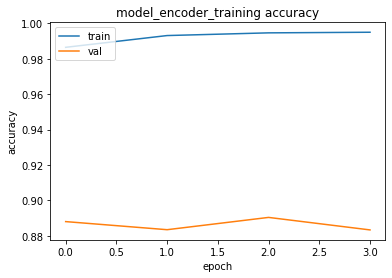

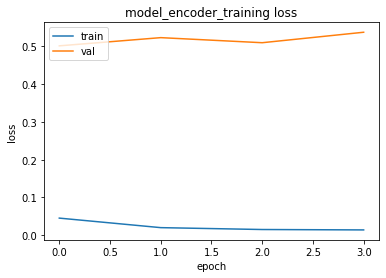

10 examples from test data...
Input                                                          Expected                                                       Predicted                                                         T/F
ank   अंक   अंक   True
anka   अंक   अंका   False
ankit   अंकित   अंकित   True
anakon   अंकों   अनकों   False
ankhon   अंकों   अंखों   False
ankon   अंकों   आंकों   False
angkor   अंकोर   अंगोर   False
ankor   अंकोर   एंकरर   False
angaarak   अंगारक   अंगारक   True
angarak   अंगारक   अंगारक   True
angraji   अंग्रज़ी   अंग्रजीी   False
angreji   अंग्रज़ी   अंग्रजीी   False
angrzi   अंग्रज़ी   अंग्रजीी   False
antah   अंतः   अनठः   False
antaha   अंतः   अंठःा   False
antarmukh   अंतर्मुख   अंतर्मुख   True
antmurkh   अंतर्मुख   अंतर्मुख   True
antrmukh   अंतर्मुख   अंतर्मुख   True
andrabee   अंद्राबी   अंड्रबबी   False
andrabi   अंद्राबी   अंड्रजबी   False
andha   अंधा   अंधा   True
andhapan   अंधापन   अंधपपन   False
andheri   अंधेरी   अंधररी   False
ambaani   अंबानी 

In [ ]:
train_test(model_encoder_training, [encoder_input_data, decoder_input_data], decoder_target_data ,
           [encoder_input_test, decoder_input_test], 
           decoder_target_test, epochs=55, batch_size=64, patience=3,verbose=2)

In [ ]:
# Define sampling models (modified for n-layer deep network)
encoder_model = Model(encoder_inputs, encoder_states)
d_outputs = decoder_inputs
decoder_states_inputs = []
decoder_states = []
for j in range(len(latent_dims))[::-1]:
    current_state_inputs = [Input(shape=(latent_dims[j],)) for _ in range(2)]

    temp = output_layers[len(latent_dims)-j-1](d_outputs, initial_state=current_state_inputs)

    d_outputs, cur_states = temp[0], temp[1:]

    decoder_states += cur_states
    decoder_states_inputs += current_state_inputs

decoder_outputs = decoder_dense(d_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

In [ ]:
def decode_sequence(input_seq, encoder_model=encoder_model, decoder_model=decoder_model):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, input_dimension))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, 0] = 1 

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = []  #Creating a list then using "".join() is usually much faster for string creation
    while not stop_condition:
        to_split = decoder_model.predict([target_seq] + states_value)

        output_tokens, states_value = to_split[0], to_split[1:]

       


        # convert the token/output prediction to a token/output
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = sampled_token_index
        # add the predicted token/output to output sequence
        decoded_sentence.append(sampled_char)



        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == 0 or len(decoded_sentence) >=  max_output_sequence:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, input_dimension))
        target_seq[0, 0, sampled_token_index] = 1.

    return decoded_sentence


In [ ]:
print('Input \t\t\t\t\t  Expected  \t\t\t   Predicted \t\t\t\t\t\t\t T/F')
correct =0 
sampleNo =  100
for sample in range(0,sampleNo):
  predicted= decode_sequence(encoder_input_data[sample].reshape(1,max_input_sequence,input_dimension),encoder_model, decoder_model)
  if (one_hot_decode(decoder_target_data[sample])== predicted+ [0] * (max_output_sequence- len(predicted))):
    correct+=1
  print( one_hot_decode(encoder_input_data[sample]), '\t\t', 
        one_hot_decode(decoder_target_data[sample]),'\t', predicted,
        '\t\t',one_hot_decode(decoder_target_data[sample])== predicted+ [0] * (max_output_sequence- len(predicted)))
print('Accuracy: ', correct/sampleNo)

Input 					  Expected  			   Predicted 							 T/F
[1, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 		 [6, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [6, 41, 0] 		 False
[1, 14, 11, 7, 1, 14, 9, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 		 [6, 3, 22, 24, 36, 64, 37, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [6, 3, 22, 24, 36, 64, 37, 0] 		 True
[21, 14, 3, 12, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 		 [6, 3, 22, 51, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [6, 3, 22, 51, 0] 		 True
[1, 14, 11, 21, 18, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 		 [6, 3, 22, 66, 49, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [6, 3, 22, 66, 49, 0] 		 True
[1, 14, 11, 21, 18, 1, 14, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 		 [6, 3, 22, 66, 49, 36, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 	 [6, 3, 22, 66, 49, 36, 0] 		 True
[1, 14, 11, 21, 18, 9, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 		 [6, 3, 22, 66, 49, 64, 37, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
print('Input \t\t\t\t\t  Expected  \t\t\t   Predicted \t\t\t\t\t\t\t T/F')
correct =0 
sampleNo =  10
for sample in range(0,sampleNo):
  predicted= decode_sequence(encoder_input_data[sample].reshape(1,max_input_sequence,input_dimension),encoder_model, decoder_model)
  if (one_hot_decode(decoder_target_data[sample])== predicted+ [0] * (max_output_sequence- len(predicted))):
    correct+=1
  print( printInputWord(one_hot_decode(encoder_input_data[sample])), '\t\t\t\t\t', 
        printTargetWord(one_hot_decode(decoder_target_data[sample])),'\t\t\t ',  printTargetWord(predicted),
        '\t\t\t\t\t\t\t',one_hot_decode(decoder_target_data[sample])== predicted+ [0] * (max_output_sequence- len(predicted)))
print('Accuracy: ', correct/sampleNo)

Input 					  Expected  			   Predicted 							 T/F
an 					 अं 			  अन 							 False
ankganit 					 अंकगणित 			  अंकगणित 							 True
uncle 					 अंकल 			  अंकल 							 True
ankur 					 अंकुर 			  अंकुर 							 True
ankuran 					 अंकुरण 			  अंकुरण 							 True
ankurit 					 अंकुरित 			  अंकुरित 							 True
aankush 					 अंकुश 			  अंकुश 							 True
ankush 					 अंकुश 			  अंकुश 							 True
ang 					 अंग 			  अंग 							 True
anga 					 अंग 			  अंग 							 True
Accuracy:  0.9


In [ ]:
correct =0 
sampleNo =  4500

predicted= model.predict(X_test[:sampleNo], batch_size=batch_size)
for sample in range(0,sampleNo):
    if (one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample])):
        correct+=1
    print( printInputWord(one_hot_decode(X_test[0][sample])), ' ', 
                printTargetWord(one_hot_decode(y_test[sample])),' ', printTargetWord(one_hot_decode(predicted[sample])),
                ' ',one_hot_decode(y_test[sample])== one_hot_decode(predicted[sample]))
print('Accuracy: ', correct/sampleNo)

In [ ]:
test_input_texts[3]

'anakon'

In [ ]:
test_word_set = test_input_texts
X_test_word=createDataset(test_word_set,eng_alpha2index)
X_test_word_padded=pad_sequences(X_test_word, maxlen= max_input_sequence, padding='post', value=eng_pad)
print("X_test_word shape: ",X_test_word.shape)
print("X_test_word_padded shape: ",X_test_word_padded.shape)
encoder_test_word_input_data = X_test_word_padded.copy()
correct =0 
sampleNo=4500
for i in range(sampleNo):
    decode_seq= decode_sequence(encoder_test_word_input_data[i].reshape(1,max_input_sequence,input_dimension),encoder_model,decoder_model)
    if(test_target_texts[i]==printTargetWord(decode_seq[:-1])):
        correct  +=1
    print(test_target_texts[i],end=" ")
    print(printTargetWord(decode_seq[:-1]),end=" ")
    print(test_target_texts[i]==printTargetWord(decode_seq[:-1]))
print('Accuracy: ', correct/sampleNo)
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


X_test_word shape:  (4502,)
X_test_word_padded shape:  (4502, 21, 129)
अंक अंक True
अंक अंका False
अंकित अंकित True
अंकों अनकों False
अंकों अंखों False
अंकों आंकों False
अंकोर अंगोक्र False
अंकोर एंकर False
अंगारक अंगारक True
अंगारक अंगारक True
अंग्रज़ी अंग्रजी False
अंग्रज़ी अंग्रजी False
अंग्रज़ी अंग्रजी False
अंतः अनाथा False
अंतः अंठा False
अंतर्मुख अंतर्मुख True
अंतर्मुख अंतर्मुख True
अंतर्मुख अंतर्मुख True
अंद्राबी अंडर्बी False
अंद्राबी अंड्राबी False
अंधा अंधा True
अंधापन अंधपन False
अंधेरी अंधरी False
अंबानी अमबानी False
अंबानी अमबानी False
अकरम अक्रम False
अकापुल्को अकाउलुक False
अकापुल्को अकापुकुक False
अखंड आखंड False
अखिल आखिल False
अगवाई आगवाई False
अगवाई आगवाई False
अगस्टाइन अगुस्तिन False
अगस्टाइन अगुसूत्सकीन False
अगस्ता अगस्ता True
अगस्ता अगस्ता True
अगस्ता अगुस्ता False
अग्र एग्र False
अग्र आगरा False
अचंभा आचंभा False
अचंभा आचंभा False
अचीवमेंट अशिकेजेंट False
अचीवमेंट अशिवेंजेत False
अच्छी अच्छी True
अच्छी अच्छी True
अच्छी अछी False
अच्युत अछूत False
अछनेरा आच्चाने

In [ ]:
test_word_set = ['halchal','krishna','hare','krishna','krishnakrishna']
X_test_word=createDataset(test_word_set,eng_alpha2index)
X_test_word_padded=pad_sequences(X_test_word, maxlen= max_input_sequence, padding='post', value=eng_pad)
print("X_test_word shape: ",X_test_word.shape)
print("X_test_word_padded shape: ",X_test_word_padded.shape)
encoder_test_word_input_data = X_test_word_padded.copy()
correct =0 
sampleNo=
for i in range(sampleNo):
    decode_seq= decode_sequence(encoder_test_word_input_data[i].reshape(1,max_input_sequence,input_dimension),encoder_model,decoder_model)
    print(test_word_set[i],end=" ")
    print(printTargetWord(decode_seq[:-1]))
#print('Accuracy: ', correct/sampleNo)
    


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


X_test_word shape:  (5,)
X_test_word_padded shape:  (5, 21, 129)
halchal एचलाल
krishna कृष्ण
hare एचरे
krishna कृष्ण
krishnakrishna कृष्णेक्षरिण


In [ ]:
printTargetWord(decode_seq[:-1])

'अंगारक'

In [ ]:
print(encoder_input_data[0].shape)
encoder_test_word_input_data[0].shape

(21, 129)


(21, 129)

In [ ]:
randomlist = []
for i in range(0,10):
    n = random.randint(100,1000)
    randomlist.append(n)
print(randomlist)
for seq_index in randomlist:
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_test[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print("-")
    #print("Input sentence:", input_texts[seq_index])
    print("Input sentence:", test_input_texts[seq_index])
    print("Decoded sentence:", printTargetWord(decoded_sentence))

[145, 628, 655, 687, 591, 717, 449, 788, 941, 958]
-
Input sentence: amanathi
Decoded sentence: अमानाती
-
Input sentence: oklahoma
Decoded sentence: ओकलौहा
-
Input sentence: contemporary
Decoded sentence: कंप्यूटर्नी
-
Input sentence: kanishthikaa
Decoded sentence: कनिष्ठिका
-
Input sentence: sk
Decoded sentence: एसके
-
Input sentence: kamate
Decoded sentence: कमाते
-
Input sentence: uthen
Decoded sentence: उठाएं
-
Input sentence: kaalpi
Decoded sentence: कालपी
-
Input sentence: khinchkar
Decoded sentence: खींचकर
-
Input sentence: gandh
Decoded sentence: गांध
